In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# from beta_irt.visualization.plots import newline
# from beta_irt.visualization.plots import plot_parameters
from irt import beta_irt
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import glob
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from beta_irt.visualization.plots import plot_parameters
# from scipy.interpolate import spline
# from scipy.interpolate import make_interp_spline, BSpline

# Examplos of IRT Curves

In [ ]:
abilities = np.linspace(start= 0.0001, stop= 1.)
params_1 = np.array([[0.2, 1., 2.4],
                     [0.5, 1., 2.4],
                     [0.7, 1., 2.4]])
params_2 = np.array([[0.5, .5, 2.4],
                     [0.5, 1., 2.4],
                     [0.5, 2., 2.4]])
colors = ['red', 'black', 'blue']
p_str = ['dif', 'aj']
save_name = ['IRT_Reg_Diff', 'IRT_Reg_Discr']

In [ ]:
def exp_err(theta_i, delta_j, a_j, c_j):
    a = ((delta_j)/(1 - delta_j))**a_j
    b = ((theta_i)/(1 - theta_i))**-a_j
    return a*b*c_j

In [ ]:
fsz = 15
new_style = {'grid': False}
plt.rc('axes', **new_style)
line_sty = 'grey'
for n, params in enumerate([params_1, params_2]):
    plt.figure()
    for i, param in enumerate(params):
        responses = []
        for ability in abilities:
            responses.append(exp_err(ability, param[0], param[1], param[2]))
        plt.plot(abilities, responses, c = colors[i], label = '{} = {}'.format(p_str[n], str(param[n])))
        if n == 0:
            plt.plot([0, 0.7], [2.4, 2.4], linestyle = '--', c = line_sty, linewidth = 1)
            plt.plot([0.2, 0.2], [-.3, 2.4], linestyle = '--', c = line_sty, linewidth = 1)
            plt.plot([0.5, 0.5], [-.3, 2.4], linestyle = '--', c = line_sty, linewidth = 1)
            plt.plot([0.7, 0.7], [-.3, 2.4], linestyle = '--', c = line_sty, linewidth = 1)
            plt.xticks([0.2, 0.5, 0.7],)
        else:
            plt.plot([.5, .5], [-.3, 2.4], linestyle = '--', c = line_sty, linewidth = 1)
            plt.plot([0, .5], [2.4, 2.4], linestyle = '--', c = line_sty, linewidth = 1)
            plt.xticks([0.5],)
        plt.xlim([0, 1.05])
        plt.ylim([-.3,9])
        plt.xlabel('Ability', fontsize = fsz)
        plt.ylabel('Exp. Error', fontsize = fsz)
        plt.yticks([2.4])
    plt.legend(fontsize = fsz - 2)
    plt.savefig(save_name[n], bbox_inches = 'tight',
    pad_inches = 0)

In [ ]:
params_2 = np.array([[0.4, 0.5],
                     [0.4, 1.],
                     [0.4, 2.]])

In [ ]:
for i, param in enumerate(params_2):
    responses = []
    for ability in abilities:
        responses.append(beta_irt(ability, param[0], param[1]))
    plt.plot(abilities, responses, c = colors[i], label = 'aj = {}'.format(str(param[1])))
plt.plot([0.4, 0.4], [-.05, .5], linestyle = '--', c = line_sty, linewidth = 1)
plt.plot([-.05, 0.4], [.5, .5], linestyle = '--', c = line_sty, linewidth = 1)
plt.xticks([0, 0.4, 1])
plt.yticks([0, 0.5, 1])
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('Ability', fontsize = fsz)
plt.ylabel('Transf. Norm. Error', fontsize = fsz)
plt.legend(fontsize = fsz - 2)
plt.savefig('BIRT_REG', bbox_inches = 'tight', pad_inches = 0)

# Reading files

In [3]:
name = 'auto93'

In [4]:
names = []
path = './Results_IRT/'+name+'/'
foldernames = glob.glob(path+'*/')
keys = list(map(lambda x: int(x[:-1].split('_')[-1]), foldernames))
keys = sorted(range(len(keys)), key=lambda k: keys[k])
foldernames = list(map(lambda k: foldernames[k], keys))
names = list(map(lambda x: x.split('/')[-2], foldernames))
max_std = int(names[-1].split('_')[-1])
cmap1 = sns.cubehelix_palette(rot=-.5,light=1.5,dark=-.5,as_cmap=True)
fsz = 15
mdls = ['LR', 'Bayes', ' SVR(Lin)', ' SVR(Rbf)', 'KNR', 'DT', 'RF', 'AdaB', 'MLP100', 'MLP50-50', 'Avg', 'Opt', 'Wrs']
# chosen_i = [55, 4]

## Data set

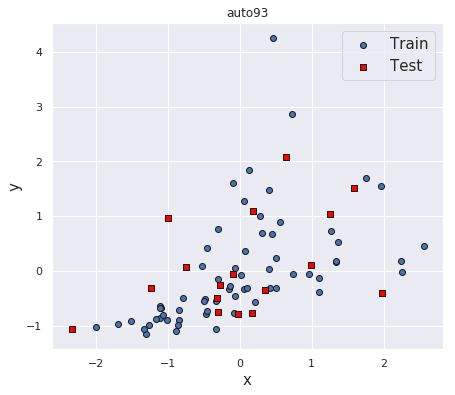

In [5]:
df = pd.read_csv('./data/' + name + '.csv', na_values=['?'])
df = df.dropna()
# X = df.iloc[:, 0].values.reshape(-1,1)
X = df.iloc[:, :-1].values

y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
inst = ['a', 'b']

# Principal component analysis
pca = PCA(n_components= 1)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))
y_test = sc_y.transform(y_test.reshape(-1,1))
    
plt.figure(figsize=(7, 6))

plt.scatter(X_train, y_train, label = 'Train',cmap = cmap1, edgecolor='k')
plt.scatter(X_test, y_test, label = 'Test', c='red',cmap = cmap1, edgecolor='k', marker='s')

# for i, pt in enumerate(chosen_i):
#     plt.plot([X_test[pt],X_test[pt] - 0.5], [y_test[pt], y_test[pt] + .02*pt], c='black')
#     plt.text(x = X_test[pt] -.7 if i == 0 else X_test[pt] - .7, y = y_test[pt]+ 1.3 if i == 0 else y_test[pt]+ 0.3, s='Inst. {}' .format(inst[i]), fontsize = fsz)
plt.ylabel('y', fontsize= fsz)
plt.xlabel('x', fontsize= fsz)
plt.legend(fontsize = fsz)
plt.title(name)
plt.savefig('./Results_IRT/' + name + '/train_test_dataset.png', bbox_inches = 'tight',
    pad_inches = 0)

In [6]:
foldernames

['./Results_IRT/auto93/noise_0/']

In [7]:
all_files = []
for i, df in enumerate(foldernames):
    path = df
    filenames = glob.glob(path + "/*.csv")
    
    filenames.sort()

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename))
        
    all_files.append(dfs)

In [8]:
abilities = np.zeros((len(mdls), len(foldernames)))
noises = np.zeros((len(foldernames), len(all_files[0][-1])))
errors = np.zeros((len(foldernames), len(all_files[0][-1]), len(mdls) - 3))
responses = np.zeros((len(foldernames), len(all_files[0][-1]), len(mdls)))
params = np.zeros((len(foldernames), len(all_files[0][-1]), 2))
test = np.zeros((len(foldernames), len(all_files[0][-1]), 2))

In [9]:
for i, data in enumerate(all_files):
    abilities[:, i] = data[1].iloc[:, -1].values
    errors[i] = np.absolute(data[0].values)
    responses[i] = data[2].values
    params[i] = data[3].values
    noises[i] = data[-2].values.reshape(1,-1)[0]
    if all_files[0][-1].shape[1] > 2:
        # Principal component analysis
        test[i][:, 0] = X_test.reshape(1,-1)[0]
        test[i][:, 1] = data[-1].iloc[:, -1].values[:]
    else:
        test[i] = data[-1].values

# Data set (Diff x Disc)

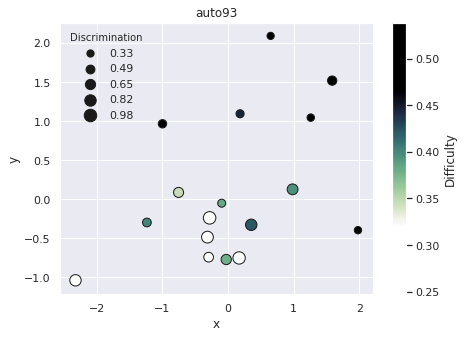

In [10]:
plt.figure(figsize=(7, 5))
size = 160
# Extract the data we're interested in
x, y = test[0][:, 0], test[0][:, 1]
diff, disc = params[0][:,0], params[0][:,1]

# Scatter the points, using size and color but no label
plt.scatter(x, y, label=None,
            c=diff, cmap=cmap1,
            s=size*disc, edgecolors='k')
plt.axis(aspect='equal')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Difficulty')
plt.clim(params[0][:,0].min(), params[0][:,0].max())

# Here we create a legend:
# we'll plot empty lists with the desired size and label

for area in np.linspace(params[0][:,1].min(), params[0][:,1].max(), num = 5):
    plt.scatter([], [], c='k', s=size*area,
                label='%.2f'%(area))
plt.legend(scatterpoints=1, frameon=False, labelspacing=.5, title='Discrimination')
plt.title(name)
plt.savefig('./Results_IRT/' + name + '/x_y_difdisc.png'.format(str(i)), bbox_inches = 'tight',
    pad_inches = 0)

## Diff x Disc (Error)

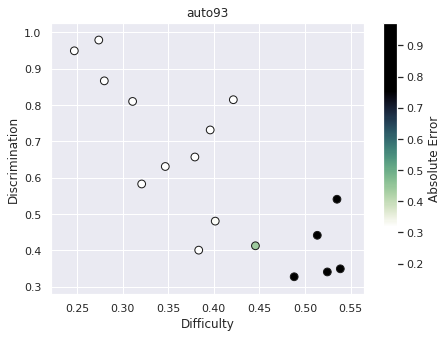

In [11]:
plt.figure(figsize=(7, 5))
# Extract the data we're interested in
x, y = params[0][:,0], params[0][:,1]
error = errors[0].mean(axis=1)

# Scatter the points, using size and color but no label
plt.scatter(x, y, label=None, s = 60,
            c=error, cmap=cmap1, edgecolors='k')
plt.axis(aspect='equal')
plt.xlabel('Difficulty')
plt.ylabel('Discrimination')
plt.colorbar(label='Absolute Error')
plt.clim(error.min(), error.max())

plt.title(name)
plt.savefig('./Results_IRT/' + name + '/dif_disc_error.png'.format(str(i)), bbox_inches = 'tight',
    pad_inches = 0)

# Noise Analysis

## Noise x MAE

In [ ]:
mae = np.zeros((len(all_files), 10))
norm_errors = np.zeros((len(all_files), 13))
for i in range(21):
    mae[i] = np.absolute(errors[i]).mean(axis=0)
    norm_errors[i] = ((1-responses[i])/responses[i]).mean(axis=0)

In [ ]:
plt.figure(figsize=(10, 8))
for j, model in enumerate(mdls):
    if j < 10:
        plt.plot(list(range(21)), norm_errors[:, j], linewidth=0.9, label=model, marker='s',)
    else:
        plt.plot(list(range(21)), norm_errors[:, j], linewidth=0.9, label=model, marker='o', linestyle='--')
plt.xticks(range(0, 21, 2))

# plt.xlim([-.1,20.1])
# plt.ylim([-0.1, 8.0])

plt.ylabel('Absolute Error', fontsize = fsz)
plt.xlabel('Noise level', fontsize = fsz)
plt.legend(loc = 'best', ncol = 4, fontsize = fsz-2)
plt.savefig('./Results_IRT/' + name + '/norm_noise_target.png', bbox_inches = 'tight', pad_inches = 0)

## Noise x Ability

In [ ]:
plt.figure(figsize=(10, 8))
for j, model in enumerate(mdls):
    if j>9:
        plt.plot(list(range(21)), abilities[j, :], linewidth=0.9, label=model, marker='o', linestyle = '--')
    else:
        plt.plot(list(range(21)), abilities[j, :], linewidth=0.9, label=model, marker='s')
plt.xticks(range(0, 21, 2))
plt.xlim([-.1,20.1])
plt.ylim([0.3,.9])

plt.ylabel('Ability', fontsize=fsz)
plt.xlabel('Noise level', fontsize = fsz)
plt.legend(loc='best', ncol=4, fontsize=fsz-2)
plt.savefig('./Results_IRT/' + name + '/noise_ability_target.png', bbox_inches = 'tight', pad_inches = 0)

# Histograms Responses

In [ ]:
plts = ['Original', '50% Noise', '100% Noise']
plot = ['Difficulty', 'Discrimination']
noises_i = [0, 10, 20]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,3))
scale = 0
for i, noise_i in enumerate(noises_i):
    values = all_files[noise_i][2].values.reshape(-1,1)
    sns.distplot(values, ax= axes[i])
    current_scale = axes[i].get_ylim()[1] - axes[i].get_ylim()[0]
    if current_scale > scale:
        scale = current_scale
        y_lim = axes[i].get_ylim()
    axes[i].set_title(plts[i])
    axes[i].set_xlabel('Response value')
    axes[i].set_ylabel('Frequency')
for ax in axes:
    ax.set_ylim(y_lim)
    ax.set_xlim([0, 1.05])
fig.savefig('./Results_IRT/'+name+'/hists_target.png')

# IRT Parameters

In [ ]:
noises.shape

In [ ]:
for i in noises_i[1:]:
    plt.scatter(test[i][:, 0], test[i][:, 1], c= noises[i], cmap=cmap1, edgecolors='k')
    plt.ylim([test[-1][:,1].min()*1.2, test[-1][:,1].max()*1.2])
#     plt.xticks(range(-2,3))
    plt.savefig('./Results_IRT/' + name + '/y_noise_{}.png'.format(str(i)), bbox_inches = 'tight',
    pad_inches = 0)
    plt.show()

In [ ]:
scale = 0

models = [LinearRegression(), BayesianRidge(), svm.SVR(kernel= 'linear'), svm.SVR(kernel = 'rbf', gamma= 'scale', C = 5),\
    KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),\
    AdaBoostRegressor(), MLPRegressor(max_iter=1000, solver= 'lbfgs'), MLPRegressor(hidden_layer_sizes= (50,50), solver = 'lbfgs', max_iter=500, activation='logistic')]

model_pred = np.zeros((len(models), len(y_test)))
for m, model in enumerate(models):
    model.fit(X_train, y_train)
    model_pred[m] = model.predict(X_test).reshape(1,-1)

Xsort_i = np.argsort(X_test.reshape(1,-1))

sns.set_context('paper')

for i, title in enumerate(plot):
    plt.figure(figsize=(10, 6))
        
    c = params[0][:, i]
    plt.scatter(X_test, y_test, c = c.reshape(-1,1), cmap = cmap1, edgecolor='k',s=40)
    
    for j, m in enumerate(model_pred):
        plt.plot(X_test[Xsort_i][0], m[Xsort_i].reshape(-1,1), linewidth = 0.5, label = mdls[j])

    plt.hlines(y = y_test.mean(), xmin = X_test.min(), xmax = X_test.max(), color = 'black')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
#     plt.show()

    plt.savefig('./Results_IRT/' + name + '/param_'+ title +'_pred.png', bbox_inches = 'tight',pad_inches = 0)

In [ ]:
scale = 0
fig, axes = plt.subplots(2, 3, figsize=(21,10))

for i, title in enumerate(plot):
    for j,noise in enumerate(noises_i):        
        axes[i,j].set_ylim([1.1*test[-1][:, 1].min(), 1.1*test[-1][:, 1].max()])
#         axes[i,j].set_ylim([.85*test[-1][:, 1].min(), 1.15*test[-1][:, 1].max()])    
        
        c = params[noise][:, i]
        
        sns.set_context('paper')

        axes[i, j].scatter(test[noise][:, 0], test[noise][:, 1], c = c, cmap = cmap1, edgecolor='k',s=30)
        
        axes[i,j].set_xlabel('x (' + plts[j]+')')
        axes[i,j].set_ylabel('y')
        axes[i,j].set_title(title + (' (ẟ)' if i == 0 else ' (a)'))
plt.savefig('./Results_IRT/' + name + '/params_noise_target.png')

# Difficulty/ Discrimination

In [ ]:
Xsort_i = np.argsort(test[0][:, 0].reshape(1,-1))
X_test = test[0][:, 0]
p_mean = params.mean(axis=0)
p_std = params.std(axis=0)

In [ ]:
p_x = pd.Series(params[0][:, 0])
ma = p_x.rolling(window=3).mean()

In [ ]:
for i, param in enumerate(plot):
    plt.figure(figsize=(10, 8))
    x = X_test[Xsort_i].reshape(1,-1)[0]
    pmean = pd.Series(params[0, Xsort_i, i][0])
    pmean1 = pd.Series(params[10, Xsort_i, i][0])
    pmean2 = pd.Series(params[20, Xsort_i, i][0])
#     pstd = pd.Series(p_std[Xsort_i, i][0])
    
#     axes[i].fill_between(x, y1 = (pmean - 2*pstd).rolling(window=4).mean(), y2 = (pmean + 2*pstd).rolling(window=4).mean(), alpha=0.2)
    plt.plot(x, pmean.rolling(window=6, min_periods =2).mean(), label = 'Original dataset', linewidth=1.5)
    plt.plot(x, pmean1.rolling(window=6, min_periods =2).mean(), label = '$σ_y$ = 0.25', linewidth=1.5)
    plt.plot(x, pmean2.rolling(window=6, min_periods =2).mean(), label = '$σ_y$ = 0.5', linewidth=1.5)
    
#     axes[i].plot(x, (pmean - 2*pstd).rolling(window=4).mean(), linewidth = 0.5, c='black')
#     axes[i].plot(x, (pmean + 2*pstd).rolling(window=4).mean(), linewidth = 0.5, c='black')
    plt.xlabel('x', fontsize=fsz)
    plt.xlim([x[0], x[-1]])
    plt.ylabel(param, fontsize=fsz)
    plt.xticks(fontsize=fsz-2)
    plt.yticks(fontsize=fsz-2)
# plt.savefig('./Results_IRT/' + name + '/params_x.png')
    plt.legend(fontsize=fsz-2)
#     plt.show()
    
    plt.savefig('./Results_IRT/'+name+'/'+ param + '_x_target.png', bbox_inches = 'tight',pad_inches = 0)

In [ ]:
#Lower noise
scale = 0
fig, axes = plt.subplots(2, 2, figsize=(12,12))

for i, title in enumerate(plot):
    for j,noise in enumerate(noises_i[1:]):
        if i == 0:
            lim = np.array([0,1])
        else:
            lim = np.array([-0.2, 1.2])
        
        axes[i,j].set_xlim(lim)
        axes[i,j].set_ylim(lim)
        axes[i,j].plot([lim[0],lim[1]], [lim[0], lim[1]], linewidth=0.2, c='black')        
        
        sns.set_context('paper')

        axes[i,j].text(x = lim[0], y = lim[0], s='Corr = %.2f' %(spearmanr(a = params[0][:, i], b = params[noise][:, i])[0]))
        axes[i, j].scatter(params[0][:, i], params[noise][:, i], c = noises[noise], cmap = cmap1, edgecolor='k',s=30)

        axes[i,j].set_xlabel("Original data")
        axes[i,j].set_ylabel(plts[j+1])
        axes[i,j].set_title(title)
fig.savefig('./Results_IRT/'+name+'/parameters_target.png')

In [ ]:
params[0]

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, noise in enumerate(noises_i):
    plt.figure(figsize=(6, 6))
    c = np.absolute(noises[i])

    plt.scatter(params[noise][:,0], params[noise][:,1], c = c, cmap = cmap1, edgecolor='k',s=30)
    plt.text(x = 0, y = -.2, s='Corr = %.2f' %(spearmanr(a = params[noise][:,0], b= params[noise][:,1])[0]))

#     plt.title(plts[i])
    plt.xlim([0,1])
    plt.ylim([-0.2, 1.2])
    plt.xlabel('Difficulty', fontsize=fsz)
    plt.ylabel('Discrimination',fontsize=fsz)
    plt.savefig('./Results_IRT/'+name+'/dif_disc_' + str(noise) + '_target.png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for h, param in enumerate(['Diff', 'Discrim']):
    for i, noise in enumerate(noises_i[1:]):
        axes[h, i].scatter(noises[noise], (params[noise][:, h] - params[0][:, h]), edgecolor='k',s=30)
        axes[h, i].set_ylim([-1., 1.])
        axes[h, i].set_xlim([0, noises[-1].max() + 0.1])
        axes[h, i].text(x = 0, y = -1, s='Corr = %.2f' %(spearmanr(a = noises[noise], b = (params[noise][:, h] - params[0][:, h]))[0]))

        axes[h, i].set_xlabel('|Noise|')
        axes[h, i].set_ylabel('Δ '+param+' ('+plts[i+1]+' - Original)')
fig.savefig('./Results_IRT/'+name+'/param_noise_target.png')

# Ability

In [ ]:
abilities.shape

In [ ]:
lim = [0.3, 0.8]
std = [0.25, 0.5]
for i, noise in enumerate(noises_i[1:]):
    plt.figure(figsize=(10, 8))
    for j, mdl in enumerate(mdls):
        if j < 10:
            plt.scatter(abilities[j, 0], abilities[j, noise], s = 90, label = mdl, edgecolor='k')
        else:
            plt.scatter(abilities[j, 0], abilities[j, noise], s = 90, label = mdl, edgecolor='k', marker = 's')
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xlabel('Ability (Original dataset)', fontsize=fsz)
    plt.ylabel('Ability (Noisy data)', fontsize=fsz)
    plt.plot(lim, lim, linewidth=0.2, c='black')
    plt.legend(fontsize = fsz-2)
    plt.xticks(fontsize = fsz-2)
    plt.yticks(fontsize = fsz-2)
    plt.savefig('./Results_IRT/'+name+'/ability_{}_target.png'.format(str(i)), bbox_inches = 'tight',pad_inches = 0)

# Error

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, noise in enumerate(noises_i):
    plt.figure(figsize=(6, 6))
    c = np.absolute(noises[noise])
    mean_error = np.absolute(errors[noise]).mean(axis = 1)
    diff = params[noise][:, 0]
    plt.scatter(diff,mean_error, c= c, cmap = cmap1, edgecolor='k',s=30)
#     plt.text(x = 0, y = 0, s='Mean = %.2f Std = %.2f Corr = %.2f' %(mean_error.mean(), mean_error.std(), spearmanr(a = diff, b = mean_error)[0]), fontsize=10)
    plt.xlabel('Difficulty', fontsize=fsz)
    plt.ylabel('Average Error (Instance)', fontsize=fsz)
    plt.xlim([0,1])
    plt.ylim([0, 1.2*np.absolute(errors[-1]).mean(axis = 1).max()])
#     plt.title(plts[i])
    plt.savefig('./Results_IRT/'+name+'/diff_error_' + str(noise) + '_target.png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
for i, noise in enumerate(noises_i[1:]):
    mean_error = np.absolute(errors[noise]).mean(axis = 1)
    axes[i].scatter(noises[noise], mean_error, edgecolor='k',s=30)
    axes[i].text(x = 0, y = 0, s='Corr = %.2f' %(spearmanr(a = noises[noise], b = mean_error)[0]), fontsize=10)
    axes[i].set_xlabel('|Noise|')
    axes[i].set_ylabel('Mean Error (Instance)')
    axes[i].set_xlim([-0.01, 1.5])
    axes[i].set_ylim([0, 1.05*np.absolute(errors[-1]).mean(axis = 1).max()])
    axes[i].set_title(plts[i+1])
fig.savefig('./Results_IRT/'+name+'/noise_error_target.png')

In [ ]:
for h, param in enumerate(plot):
    sns.set_context('paper')
    scale = 0
    fig, axes = plt.subplots(1, 3, figsize=(18,2))
    for i, noise in enumerate(noises_i):
        values = params[noise][:, h]
        sns.distplot(values,bins=100,ax=axes[i])
        sns.distplot(values, ax= axes[i])
        current_scale = axes[i].get_ylim()[1] - axes[i].get_ylim()[0]
        if current_scale > scale:
            scale = current_scale
            y_lim = axes[i].get_ylim()
        axes[i].set_title(param + ' (' + plts[i] + ')')
        axes[i].set_ylabel('Frequency')
    for ax in axes:
        ax.set_ylim(y_lim)
        ax.set_xlim([-0.1, 1.2])
    fig.subplots_adjust(hspace=0.3)
    fig.savefig('./Results_IRT/'+name+'/hists_' + param + '_target.png')

In [ ]:
ind = np.lexsort((params[0,:,0], params[0,:,1]))

In [ ]:
params[0, ind,:]

In [ ]:
ind

## Response

In [ ]:
# +Diff+Disc/ -Diff-Disc/ -Diff+Disc/ +Diff-Disc
chosen_i = [55, 0, 15, 37]
ab = np.linspace(0.0001, 0.9999, 200)
sub_noise = ['Noise free', '50% Noise', '100% Noise']

for j in (chosen_i):
    plt.figure(figsize=(6, 6))
    par = params[0, j, :]
    diff = par[0]
    disc = par[1]
    E = [beta_irt(x, diff, disc) for x in ab]
    middle = np.where(np.array(E)>0.499)[0][:2]
    p1 = [ab[middle[0]], E[middle[0]]]
    p2 = [ab[middle[1]], E[middle[1]]]
    newline(p1,p2)
    slope = (E[middle[1]] - E[middle[0]])/(ab[middle[1]] - ab[middle[0]])
    plt.text(p2[0], p2[1], 'slope = '+str(round(slope, 3)),fontsize=15)
    plt.plot(ab, E,)
    plt.plot([ab[middle[0]], ab[middle[0]]],[0, E[middle[0]]], '--r')
    plt.plot([0, ab[middle[0]]],[E[middle[0]], E[middle[0]]], '--r')
    plt.scatter(abilities[:, 0], responses[0, j, :], marker= 'x', c = 'red')
    plt.ylabel('Response', fontsize=fsz)
    plt.xlabel('Ability', fontsize=fsz)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
#     plt.title('Instance ' + str(j))
#         plt.legend()
    plt.savefig('./Results_IRT/'+name+'_TARGET/instance_' + str(j) + '.png')

## Relative Error

In [ ]:
# +Diff+Disc/ -Diff-Disc/ -Diff+Disc/ +Diff-Disc
ab = np.linspace(0.0000000000001, 0.999999999999, 50000)
sub_noise = ['Noise free', '50% Noise', '100% Noise']

for j in (chosen_i):
    plt.figure(figsize=(6, 6))
    par = params[0, j, :]
    diff = par[0]
    disc = par[1]
    E = [beta_irt(x, diff, disc) for x in ab]
    E = list(map(lambda res: (1-res)/res, E))
#     middle = np.where(np.array(E)>0.499)[0][:2]
#     p1 = [ab[middle[0]], E[middle[0]]]
#     p2 = [ab[middle[1]], E[middle[1]]]
#     newline(p1,p2)
#     slope = (E[middle[1]] - E[middle[0]])/(ab[middle[1]] - ab[middle[0]])
#     plt.text(p2[0], p2[1], 'slope = '+str(round(slope, 3)),fontsize=15)
    plt.plot(ab, E, linewidth=2.5, label = 'Difficulty = {0:.2f}\n\nDiscrimination = {1:.2f}'.format((diff), (disc)))
    response = responses[0][j, :]
    plt.scatter(abilities[:, 0], (1-response)/response, marker='x', c='red', s=50)
#     plt.plot([ab[middle[0]], ab[middle[0]]],[0, E[middle[0]]], '--r')
#     plt.plot([0, ab[middle[0]]],[E[middle[0]], E[middle[0]]], '--r')
#     plt.scatter(abilities[:, 0], responses[0, j, :], marker= 'x', c = 'red')
    plt.ylabel('Normalised Error', fontsize=fsz+2)
    plt.xlabel('Ability', fontsize=fsz+2)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.5, 16])
    plt.legend(fontsize = fsz, handlelength=0, handletextpad=0, fancybox=True)
#     plt.title('Instance ' + str(j))
#         plt.legend()
    plt.savefig('./Results_IRT/'+name+'/err_instance_' + str(j) + '_target.png', bbox_inches = 'tight',
    pad_inches = 0)

# Percentual variation

In [ ]:
mean_errors = np.absolute(errors).mean(axis=1).T

In [ ]:
var_ab = np.zeros((len(abilities)-3, abilities.shape[1]-1))
var_ab.shape
var_error = np.zeros((len(abilities)-3, abilities.shape[1]-1))
var_error.shape

In [ ]:
for i, noise_i in enumerate(range(1, abilities.shape[1])):
    var_ab[:, i] = 100*np.absolute(abilities[:-3, noise_i] - abilities[:-3, 0])/abilities[:-3, 0]
    var_error[:, i] = 100*np.absolute(mean_errors[:, noise_i] - mean_errors[:, 0])/mean_errors[:, 0]

In [ ]:
var_error.shape

In [ ]:
np.sum(var_ab <= var_error)

In [ ]:
df = pd.DataFrame((var_ab - var_error).T, index=np.arange(1,21), columns=mdls[:-3]).round(decimals=3)

In [ ]:
df.values.sum()

## Teste t-pareado

In [ ]:
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp

In [ ]:
ttest_rel(a=var_ab.reshape(-1,1)[:,0], b=var_error.reshape(-1,1)[:,0])

In [ ]:
ks_2samp(data1=var_ab.reshape(-1,1)[:,0], data2=var_error.reshape(-1,1)[:,0],alternative='less')

In [ ]:
import seaborn as sns

cm = sns.cubehelix_palette(10, start=2, rot=0, dark=0, light=.95, reverse=True)
plt.subplots(figsize=(12,7))
s = sns.heatmap(data= df, cmap=cm, annot=True, )